In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import initializers
from keras.datasets import mnist
import matplotlib.pyplot as plt
from IPython import display

In [2]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [3]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [4]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [5]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 5s 2ms/step - loss: 190.6552 - val_loss: 173.7087
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 170.7270 - val_loss: 167.9145
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 166.1726 - val_loss: 164.7261
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 163.0928 - val_loss: 161.9464
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 160.7710 - val_loss: 160.0486
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 159.1634 - val_loss: 158.5252
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 157.9101 - val_loss: 159.0416
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 156.9552 - val_loss: 156.5769
Epoch 9/100
1875/1875 [==============================] - 4s 2ms/step - loss: 156.1534 - val_loss: 156.1447
Epoch 10/100
1875/1875 [=============

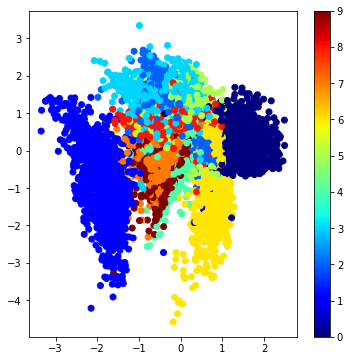

In [21]:
x_test_encoded = encoder.predict(x_test, batch_size=1)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], c=y_test, cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.show()